Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE.txt and README.txt for information on usage and licensing

# SIR Model

**Network SIR Model with Non-Markovian Transitions**

The EoN package allows for non-Markovian transitions, but only for SIR and SIS contagions (see [here](https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_nonMarkov_SIR.html#EoN.fast_nonMarkov_SIR)). Therefore, while the SIR model is one of the simplest epidemic models and certainly does not capture all of the complexities of COVID-19, here we will model the pandemic using this model:
- $S \rightarrow I$ occurs at a rate $\beta$
- $I \rightarrow R$ occurs after precisely $D$ time has elapsed

In more detail, this means that once the neighbor of suspectible node becomes infected, a random draw is made from an exponential distribution with rate parameter $\beta$. Let's call this variable $\tau$ as it represents a time scale. If $\tau \le D$, then the infection spreads, causing a node transition $S \rightarrow I$ after $\tau$ time elapses. If $\tau > D$, then the infected node recovers before the infection can spread, and the $S$ node remains $S$. 

**Transmission Probability**

The probability that the disease will be transmitted before the infected node recovers, $p(\beta)$, can be easily calculated:

$$ p(\beta) = \int_0^D d\tau \, \beta e^{-\beta \tau} = 1 - e^{-\beta D} \,, $$

where the integrand is just the probability density of the exponential distribution. For very small rates this can be well approximated the linear relation $p \approx \beta D$. 

**Edge Weights**

In addition, in this notebook we will incorporate the contact time between nodes. This is represented by the weight $w_{ij}$ of an edge $(i,j)$. How should the edge weight affect the transmission probability? The simplest approach, and the one which we will adopt, is to simply rescale the transmission rate by the edge weights, i.e. $\beta_{ij} = w_{ij} \beta$. The transmission probability then becomes $p(\beta_{ij}) = 1 - e^{-w_{ij} \beta D}$. 

In [1]:
import collections, os, pickle
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import random, scipy

from utils import *
import EoN

import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.style.use('figures/theme_bw.mplstyle')
%matplotlib inline

fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
## set seed
random.seed(123)
np.random.seed(123)

In [3]:
## load the contact network
#G = nx.read_gpickle("data/G_superposition.gpickle")

G = nx.read_weighted_edgelist("data/G_superposition.adjlist", nodetype=float)

In [4]:
def scaled_beta(beta0, weight):
    '''rescale the transmission rate by the contact time'''
    return weight*beta0
    
    
def trans_time_fxn(source, target, beta0):
    '''transmission function'''
    x0, x1 = np.sort([source, target])
    weight = G[x0][x1]['weight']
    betaij = scaled_beta(beta0, weight)
    return random.expovariate(betaij)


def rec_time_fxn(node, D):
    '''recovery time function'''
    return D


def rec_time_fxn_improved(node, Ddict):
    '''
    improved recovery time function, capable 
    of having a distinct R time for each node
    '''
    return Ddict[node]

## Example Run

In [5]:
## SIR parameters
D = 14
beta0 = 10

## pick a random degree-50 node to start the epidemic
initial_infecteds = np.random.choice(degree_getter(G, 50), 1)[0]

result = EoN.fast_nonMarkov_SIR(G,
                                trans_time_fxn=trans_time_fxn,
                                rec_time_fxn=rec_time_fxn,
                                trans_time_args=(beta0,),
                                rec_time_args=(D,),
                                initial_infecteds = initial_infecteds,
                                return_full_data=True)

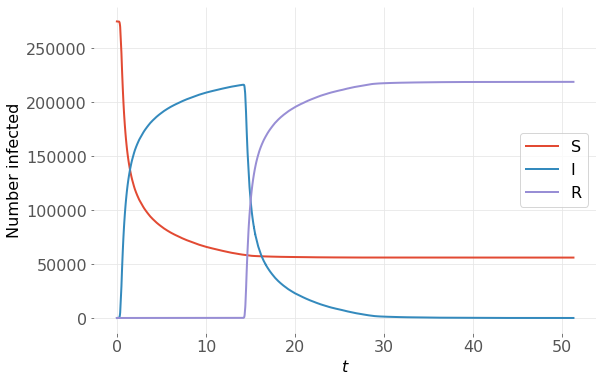

In [7]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(result.summary()[0], result.summary()[1]['S'], lw=2, label='S')
ax.plot(result.summary()[0], result.summary()[1]['I'], lw=2, label='I')
ax.plot(result.summary()[0], result.summary()[1]['R'], lw=2, label='R')

ax.set_xlabel('$t$')
ax.set_ylabel('Number infected')
ax.legend()
plt.show()

Let's verify that the 14 day recovery period is firm. Let me inspect the history of the initial seed node, one of that nodes neighbors, and a random node (node 0). We can see that there is a 14 day lag between when a node is first infected and when it transitions to the R state.

In [7]:
## the 3 nodes we'll inspect
[initial_infecteds] + list(G.neighbors(initial_infecteds))[0:1] + [0] 

[2260337, 3591526, 0]

In [8]:
## the simulation results restricted to these nodes
## the first entry is the list of Gillespie times, 
## the second is an S,I,R dict of node statuses at those times
result.summary(nodelist=[initial_infecteds] + list(G.neighbors(initial_infecteds))[0:1] + [0] )

(array([ 0.        ,  0.46065861, 14.        , 14.46065861]),
 {'S': array([2, 1, 1, 1]),
  'I': array([1, 2, 1, 0]),
  'R': array([0, 0, 1, 2])})

## Vaccination Strategies

Vaccination will be enforced by moving nodes from the S state into the R state.

In [9]:
def vaccination_uniform(G, Snodes, Rnodes, f):
    '''uniform vaccination'''
    
    ## number of nodes to vaccinate
    num_vacc = int(f*len(Snodes))    
    
    ## identify nodes to vaccinate    
    Vnodes = np.random.choice(Snodes, num_vacc, replace=False)
    
    ## move vaccinated nodes from S to R compartments
    SnodesNew = np.asarray(list(set(Snodes).difference(Vnodes)))
    RnodesNew = np.asarray(list(set(Rnodes).union(Vnodes)))
    
    return SnodesNew, RnodesNew, Vnodes


def vaccination_top(G, Snodes, Rnodes, f):
    '''vaccinate the highest degree nodes'''
    
    ## number of nodes to vaccinate    
    num_vacc = int(f*len(Snodes))    

    ## create a sorted array of (node_id, degree) for the Snodes
    degree_array = np.asarray(list(G.degree(Snodes)))
    degree_array = np.asarray(sorted(degree_array, key=lambda entry: -entry[1]))

    ## identify nodes to vaccinate
    Vnodes = degree_array[:num_vacc, 0]
    
    ## move vaccinated nodes from S to R compartments
    SnodesNew = np.asarray(list(set(Snodes).difference(Vnodes)))
    RnodesNew = np.asarray(list(set(Rnodes).union(Vnodes)))
    
    return SnodesNew, RnodesNew, Vnodes


def vaccination_top_imperfect(G, Snodes, Rnodes, f, x):
    '''
    Vaccinate a fraction (f/x) of the top x fraction of nodes. For example,
    if f = 0.15 and x = 1/3, then 45% of the top 33.3% of nodes will be 
    vaccinated. The total fraction of vaccinated nodes is f.
    '''
    
    ## create a sorted array of (node_id, degree) for the Snodes
    degree_array = np.asarray(list(G.degree(Snodes)))
    degree_array = np.asarray(sorted(degree_array, key=lambda entry: -entry[1]))

    ## grab top x% of nodes by degree
    degree_array = degree_array[:int(x*degree_array.shape[0]), :]
    
    ## identify nodes to vaccinate
    Vnodes = np.random.choice(degree_array.shape[0], int(f/x*degree_array.shape[0]), replace=False)
    Vnodes = degree_array[Vnodes, 0]
    
    ## move vaccinated nodes from S to R compartments
    SnodesNew = np.asarray(list(set(Snodes).difference(Vnodes)))
    RnodesNew = np.asarray(list(set(Rnodes).union(Vnodes)))
    
    return SnodesNew, RnodesNew, Vnodes


def vaccination_bottom(G, Snodes, Rnodes, f):
    '''vaccinate the lowest degree nodes'''
    
    ## number of nodes to vaccinate    
    num_vacc = int(f*len(Snodes))    

    ## create a sorted array of (node_id, degree) for the Snodes
    degree_array = np.asarray(list(G.degree(Snodes)))
    degree_array = np.asarray(sorted(degree_array, key=lambda entry: entry[1]))

    ## identify nodes to vaccinate
    Vnodes = degree_array[:num_vacc, 0]
    
    ## move vaccinated nodes from S to R compartments
    SnodesNew = np.asarray(list(set(Snodes).difference(Vnodes)))
    RnodesNew = np.asarray(list(set(Rnodes).union(Vnodes)))
    
    return SnodesNew, RnodesNew, Vnodes


Test the vaccination strategies, applying them both at some early time $t_1$ and at some later time $t_2$:

### Uniform Vaccination

In [10]:
## early time (measured in days)
t1 = result.summary()[0][10000]
t1

0.4145104962383981

In [11]:
## get the node states at t=t1
Snodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'R']

print('Number of S nodes: %i' %len(Snodes))
print('Number of I nodes: %i' %len(Inodes))
print('Number of R nodes: %i' %len(Rnodes))

Number of S nodes: 264778
Number of I nodes: 10001
Number of R nodes: 0


In [12]:
## check that every node is either S, I, or R
len(Snodes + Inodes + Rnodes) == G.number_of_nodes()

True

In [13]:
## perform the vaccination
Snodes_new, Rnodes_new, Vnodes = vaccination_uniform(G, Snodes, Rnodes, 0.15)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 264778
Number of S nodes after vaccination: 225062
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 0
Number of R nodes after vaccination: 39716


Note that $t_1$ is early enough that no nodes have entered the R state. If this is not the case, then we need to specify what is meant by vaccinating a fraction of the nodes: does that fraction apply to the remaining S nodes, or to the entire graph? Here we are vaccinating a fraction of the remaining S nodes. Let's verify this by looking at a later time, $t_2$.

In [14]:
t2 = result.summary()[0][350000]
t2

15.376069730155772

In [15]:
## get the node states at t=t2
Snodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'R']

print('Number of S nodes: %i' %len(Snodes))
print('Number of I nodes: %i' %len(Inodes))
print('Number of R nodes: %i' %len(Rnodes))

Number of S nodes: 57628
Number of I nodes: 84301
Number of R nodes: 132850


In [16]:
Snodes_new, Rnodes_new, Vnodes = vaccination_uniform(G, Snodes, Rnodes, 0.15)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 57628
Number of S nodes after vaccination: 48984
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 132850
Number of R nodes after vaccination: 141494


### Targeted (Top) Vaccination

In [17]:
## get the node states at t=t1
Snodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'R']

In [18]:
Snodes_new, Rnodes_new, Vnodes = vaccination_top(G, Snodes, Rnodes, 0.15)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 264778
Number of S nodes after vaccination: 225062
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 0
Number of R nodes after vaccination: 39716


As before, let's make sure we are vaccinating a constant fraction of S nodes, and not a fraction of the total nodes. The distinction matters if the vaccination occurs late enough that the number of R nodes is non-zero (i.e. if the vaccination time is larger than 14 days). 

In [19]:
## get the node states at t=t2
Snodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'R']

In [20]:
Snodes_new, Rnodes_new, Vnodes = vaccination_top(G, Snodes, Rnodes, 0.15)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 57628
Number of S nodes after vaccination: 48984
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 132850
Number of R nodes after vaccination: 141494


### Targeted (Bottom) Vaccination

In [21]:
## get the node states at t=t1
Snodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'R']

Snodes_new, Rnodes_new, Vnodes = vaccination_bottom(G, Snodes, Rnodes, 0.15)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 264778
Number of S nodes after vaccination: 225062
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 0
Number of R nodes after vaccination: 39716


### Imperfect Targeted (Top) Vaccination

In [22]:
## get the node states at t=t1
Snodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t1).items() if v == 'R']

Snodes_new, Rnodes_new, Vnodes = vaccination_top_imperfect(G, Snodes, Rnodes, 0.15, 0.3)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 264778
Number of S nodes after vaccination: 225062
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 0
Number of R nodes after vaccination: 39716


And what if the vaccination occurs later in the simulation?

In [23]:
## get the node states at t=t2
Snodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'S']
Inodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'I']
Rnodes = [k for k,v in result.get_statuses(time=t2).items() if v == 'R']

Snodes_new, Rnodes_new, Vnodes = vaccination_top_imperfect(G, Snodes, Rnodes, 0.15, 0.3)

print('Number of S nodes before vaccination: %i' %len(Snodes))
print('Number of S nodes after vaccination: %i' %len(Snodes_new))
print('Fraction of S nodes vaccinated: %.2f' %(1-len(Snodes_new)/len(Snodes)))

print('\n')
print('Number of R nodes before vaccination: %i' %len(Rnodes))
print('Number of R nodes after vaccination: %i' %len(Rnodes_new))

Number of S nodes before vaccination: 57628
Number of S nodes after vaccination: 48984
Fraction of S nodes vaccinated: 0.15


Number of R nodes before vaccination: 132850
Number of R nodes after vaccination: 141494


## Model Calibration

Calibrate the model by selecting the transmission rate $\beta$ such that it takes 14 days for the disease to go from 50 to 500 infected.

In [24]:
def calc_Delta_T(beta0):
    '''
    Given a beta0 value, find the time for the disease 
    to go from 50 to 500 infecteds.
    '''

    ## pick a random degree-50 node to start the epidemic
    initial_infecteds = np.random.choice(degree_getter(G, 50), 1)[0]

    t, S, I, R = EoN.fast_nonMarkov_SIR(G,
                            trans_time_fxn=trans_time_fxn,
                            rec_time_fxn=rec_time_fxn,
                            trans_time_args=(beta0,),
                            rec_time_args=(D,),
                            initial_infecteds = initial_infecteds,
                            return_full_data=False,
                            tmax=200)
    
    ## in some runs the pandemic doesn't take off
    try:
        t50 = t[np.argwhere(I >= 50)[0]]
        t500 = t[np.argwhere(I >= 500)[0]]
        return (t500 - t50)[0]
    except:
        return None

In [25]:
Delta_T, beta0 = 0, 0.063
iterations = 100
betalist = []
Delta_T_list = []

cond = True
while cond:
    
    ## consider many different runs for a given beta0 to account for the variability
    Delta_T = [calc_Delta_T(beta0) for i in range(iterations)]

    ## remove the failed runs
    num_failed = np.sum([i == None for i in Delta_T])
    Delta_T = [t for t in Delta_T if t != None]

    ## take an average
    if len(Delta_T) >= 1:
        Delta_T_mean = np.mean(Delta_T)
    else:
        Delta_T_mean = -1 
        
    ## assuming none of the calibration runs failed, adjust beta0
    if Delta_T_mean != -1:
        ## record result
        Delta_T_list.append(Delta_T_mean)
        print('beta0 = %.3f, Delta T = %.3f, Failed Runs = %i/%i' \
              %(beta0, Delta_T_mean, num_failed, iterations))

        ## adjust tau
        if Delta_T_mean > 15:
            beta0 = 1.1*beta0
        elif Delta_T_mean < 13:
            beta0 = 0.9*beta0
        
        cond = not (13 < Delta_T_mean and Delta_T_mean < 15)

beta0 = 0.063, Delta T = 14.836, Failed Runs = 51/100


In [26]:
beta0

0.063

In [27]:
## how many different patient zeros are there?
degree_getter(G, 50).shape

(547,)

In [28]:
## there is a large standard deviation
print('mean = %.2f, std = %.2f' %(np.mean(Delta_T), np.std(Delta_T)))

mean = 14.84, std = 3.92


## Main Run

The strategy is to run two simulations. The first starts from the initial condition and runs without any vaccination. Then, the state of the simulation is retrieved at the moment when the number of infected first surprasses 10k. Then, a vaccination strategy is applied to this state, whereby some S nodes are converted to I nodes. Lastly, the second simulation is initiated from this state. The results are then spliced together. 

In [29]:
def run_model_SIR(beta0, D, I_transition, vacc_type, f, x, initial_infecteds, seed=0):
    '''
    This function carries out a single SIR simulation for a given vaccination strategy.
    '''
    
    random.seed(seed)
    np.random.seed(seed)

    #####################################
    ###### STEP 1: Run without Vaccination #######    
    
    while True:
        try:
            ## run the simulation
            result1 = EoN.fast_nonMarkov_SIR(G,
                                            trans_time_fxn=trans_time_fxn,
                                            rec_time_fxn=rec_time_fxn,
                                            trans_time_args=(beta0,),
                                            rec_time_args=(D,),
                                            initial_infecteds = initial_infecteds,
                                            return_full_data=True)

            ## find the time-step where the infection has grown to Itransition people
            i_transition = np.where(result1.summary()[1]['I'] == 1000)[0][0]
            t_transition = result1.summary()[0][i_transition]
            ## get the node statuses at this time
            nodes_intermediate = result1.get_statuses(time=t_transition)
            Snodes = [k for k,v in nodes_intermediate.items() if v == 'S']
            Inodes = [k for k,v in nodes_intermediate.items() if v == 'I']
            Rnodes = [k for k,v in nodes_intermediate.items() if v == 'R']

            ## find out how much time each I node has left before the R transition
            Ddict = collections.defaultdict(lambda: 14)
            for node in Inodes:
                t_infected = result1.node_history(node)[0][1]
                Delta_t_remaining = 14 - (t_transition - t_infected)
                Ddict[node] = Delta_t_remaining
    
            break
        except ValueError:
            print("Error: run failed to reach I_transition people")
        
    #####################################

    #####################################    
    ###### STEP 2: Select Vaccination ###        
    if vacc_type == 'none':
        #print('no vaccination')
        Snodes_new = Snodes
        Rnodes_new = Rnodes
        Vnodes = []
    elif vacc_type == 'uniform':
        #print('uniform vaccination')
        Snodes_new, Rnodes_new, Vnodes = vaccination_uniform(G, Snodes, Rnodes, f)
    elif vacc_type == 'top':
        #print('top vaccination')
        Snodes_new, Rnodes_new, Vnodes = vaccination_top(G, Snodes, Rnodes, f)
    elif vacc_type == 'bottom':
        #print('bottom vaccination')
        Snodes_new, Rnodes_new, Vnodes = vaccination_bottom(G, Snodes, Rnodes, f)
    elif vacc_type == 'top imperfect':
        #print('top imperfect vaccination')
        Snodes_new, Rnodes_new, Vnodes = vaccination_top_imperfect(G, Snodes, Rnodes, f, x)
    elif vacc_type == 'bottom imperfect':
        #print('bottom imperfect vaccination')
        Snodes_new, Rnodes_new, Vnodes = vaccination_bottom_imperfect(G, Snodes, Rnodes, f, x)
    else:
        print('vaccination type not recognized!')
    #####################################    

    #####################################    
    ###### STEP 3: Run with Vaccination #        
    ## run the simulation starting from t_transition
    result2 = EoN.fast_nonMarkov_SIR(G,
                                    trans_time_fxn=trans_time_fxn,
                                    rec_time_fxn=rec_time_fxn_improved,
                                    trans_time_args=(beta0,),
                                    rec_time_args=(Ddict,),
                                    initial_infecteds = Inodes,
                                    initial_recovereds = Rnodes_new,
                                    return_full_data=True)
    #####################################
   
    return result1, result2, I_transition, t_transition, Snodes_new, Rnodes, Rnodes_new, Vnodes

some helper functions

In [30]:
def summary_extraction(result):
    '''extract the SIR results from a Simulation_Investigation object'''
    t = result.summary()[0]
    S = result.summary()[1]['S']
    I = result.summary()[1]['I']
    R = result.summary()[1]['R']
    
    return t, S, I, R


def splice_results(result1, result2, I_transition, t_transition):
    '''splice together the results of simulation 1 and 2'''
    t1, S1, I1, R1 = summary_extraction(result1)
    t2, S2, I2, R2 = summary_extraction(result2)
    
    t = np.concatenate((t1[0:I_transition], t_transition + t2[1:]))
    S = np.concatenate((S1[0:I_transition], S2[1:]))
    I = np.concatenate((I1[0:I_transition], I2[1:]))    
    R = np.concatenate((R1[0:I_transition], R2[1:]))
    
    return t, S, I, R


def duration(t, I, target_fraction):
    '''return the time until the number of infected drops below a target threshold'''

    target = int(target_fraction * G.number_of_nodes())

    i = 0
    cond = True
    while cond:
        if I[i] > target and I[i+1] <= target:
            cond = False
        else:
            i += 1
            
    return t[i]

Now, scan over vaccination strategies and perform many runs of the same model in order to average the results.

In [31]:
## pick a random degree-50 node to start the epidemic
initial_infecteds = np.random.choice(degree_getter(G, 50), 10)[0]
initial_infecteds

3590558

In [32]:
G.degree[initial_infecteds]

50

Set the run parameters:

In [33]:
iterations = 100
I_transition = 1000
vacc_types = ['none', 'bottom', 'uniform', 'top imperfect', 'top']
f = 0.15
x = 0.3

First do a single run as an example:

In [41]:
result1, result2, I_transition, t_transition, Snodes_new, Rnodes, Rnodes_new, Vnodes \
    = run_model_SIR(beta0, D, I_transition, 'none', f, x, initial_infecteds, seed=3)

In [42]:
print('number of nodes vaccinated: %i' %len(Vnodes))
print('fraction of nodes vaccinated4: %.4f' %(len(Vnodes)/G.number_of_nodes()))
print('number of R nodes at moment of vaccination: %i' %len(Rnodes))

final_statuses = result2.get_statuses(nodelist=Snodes_new, time=result2.summary()[0][-1])
recovereds_after_vaccination = np.asarray([key for key, value in final_statuses.items() if value == 'R'])
print('number of non-vaccinated R nodes at the end of the run: %i' %len(recovereds_after_vaccination))

number of nodes vaccinated: 0
fraction of nodes vaccinated4: 0.0000
number of R nodes at moment of vaccination: 132
number of non-vaccinated R nodes at the end of the run: 40950


Now do the main run

vacc type: none
number of non-vaccinated R nodes at the end of the run: 41180
run failed, trying another seed, 16
run failed, trying another seed, 29
run failed, trying another seed, 36
run failed, trying another seed, 55


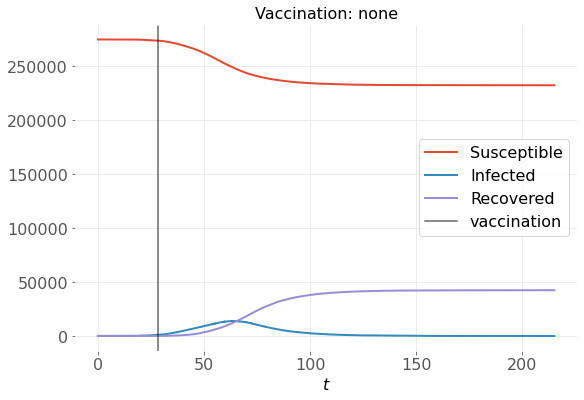

vacc type: bottom
number of non-vaccinated R nodes at the end of the run: 40297
run failed, trying another seed, 16
run failed, trying another seed, 29
run failed, trying another seed, 36
run failed, trying another seed, 55


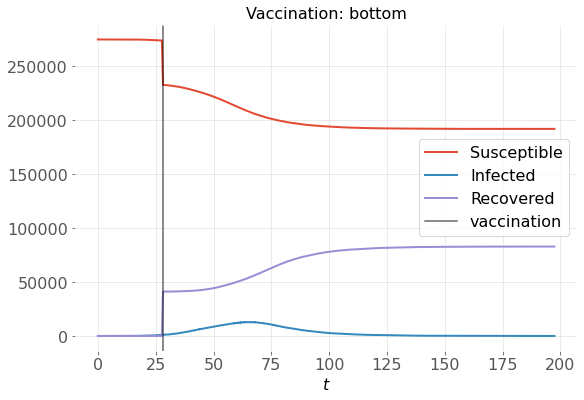

vacc type: uniform
number of non-vaccinated R nodes at the end of the run: 26926
run failed, trying another seed, 16
run failed, trying another seed, 29
run failed, trying another seed, 36
run failed, trying another seed, 55


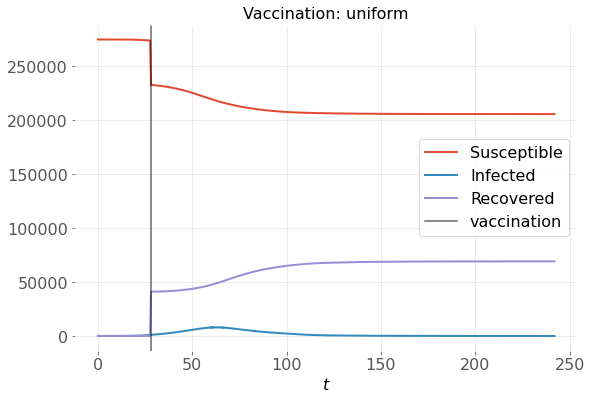

vacc type: top imperfect
number of non-vaccinated R nodes at the end of the run: 5192
run failed, trying another seed, 16
run failed, trying another seed, 29
run failed, trying another seed, 36
run failed, trying another seed, 55


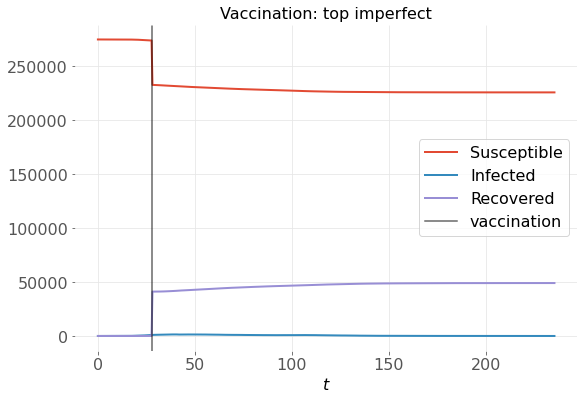

vacc type: top
number of non-vaccinated R nodes at the end of the run: 3546
run failed, trying another seed, 16
run failed, trying another seed, 29
run failed, trying another seed, 36
run failed, trying another seed, 55


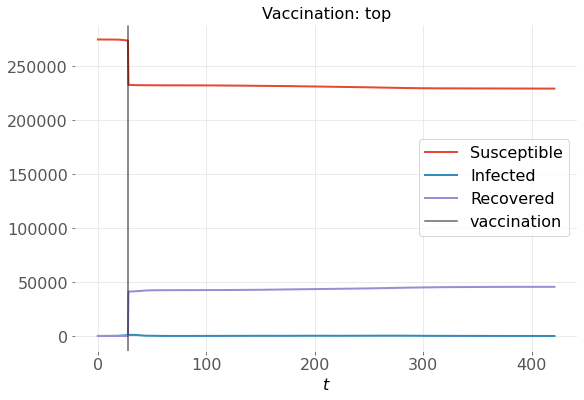

In [43]:
peak_infecteds = np.zeros((5, iterations))
total_infecteds = np.zeros((5, iterations))
seeds = np.zeros((5,iterations))
patient_zero_idx = 0
patient_zero_list = degree_getter(G, 50)

for j in range(len(vacc_types)):
    vacc_type = vacc_types[j]
    print('vacc type: %s' %vacc_type)
    seed = 0
    for i in range(iterations):
        while True:
            try:
                seed += 1
                initial_infecteds = patient_zero_list[patient_zero_idx]
                result1, result2, I_transition, t_transition, Snodes_new, Rnodes, Rnodes_new, Vnodes \
                    = run_model_SIR(beta0, D, I_transition, vacc_type, f, x, initial_infecteds, seed=seed)    
                
                t, S, I, R = splice_results(result1, result2, I_transition, t_transition)
                
                N_vaccinated = len(Vnodes)
                final_statuses = result2.get_statuses(nodelist=Snodes_new, time=result2.summary()[0][-1])
                recovereds_after_vaccination = np.asarray([key for key, value in final_statuses.items() if value == 'R'])
                break
            
            except IndexError:
                #if it failed, try another seed
                print('run failed, trying another seed, %i' %seed)
                pass

        ## save the results 
        ## I'd like the save the entire Simulation_Investigation object, 
        ## but I couldn't figure out how
        name = 'vacc_' + vacc_type + '_iteration_' + str(i) + '.txt' 
        
        ## save the summaries
        with open('data/SIR/result1_summary_' + name, 'wb') as file:
            pickle.dump(result1.summary(), file)
        with open('data/SIR/result2_summary_' + name, 'wb') as file:
            pickle.dump(result2.summary(), file)          
        ## save list of recovered nodes after vaccination
        with open('data/SIR/recovereds_after_vaccination_' + name, 'wb') as file:
            if i == 0:
                print('number of non-vaccinated R nodes at the end of the run: %i' %len(recovereds_after_vaccination))
            pickle.dump(recovereds_after_vaccination, file)

        ## record the key statistics
        peak_infecteds[j,i] = np.max(I)
        total_infecteds[j,i] = result2.summary()[1]['R'][-1] - N_vaccinated
        seeds[j,i] = seed
        
    ## make a plot
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(t, S, lw=2, label='Susceptible')
    ax.plot(t, I, lw=2, label='Infected')
    ax.plot(t, R, lw=2, label='Recovered')
    ax.axvline(x=t_transition, color='k', alpha=0.6, label='vaccination')
    ax.set_xlabel('$t$')
    ax.legend()
    plt.title('Vaccination: %s' %vacc_type)
    name = 'vacc_' + vacc_type + '_iteration_' + str(i) + '.pdf' 
    plt.savefig('figures/SIR_' + name, bbox_inches='tight', pad_inches = 0, transparent = True)
    plt.show()
    
## save the key statistics for the entire set of runs
np.save('data/SIR/seeds', seeds)
np.save('data/SIR/total_infecteds', total_infecteds)
np.save('data/SIR/peak_infecteds', peak_infecteds)

The simulation results are analyzed in a separate notebook.